# 『Machine learning phases of matter』を理解したい
## 原著論文について

https://arxiv.org/abs/1605.01735

### Abstract

Neural networks can be used to identify phases and phase transitions in condensed matter systems via supervised machine learning.

Readily programmable through modern software libraries, we show that a standard feed-forward neural network can be trained to detect multiple types of order parameter directly from raw state configurations sampled with Monte Carlo. 

In addition, they can detect highly non-trivial states such as Coulomb phases, and if modified to a convolutional neural network, topological phases with no conventional order parameter. 

We show that this classification occurs within the neural network without knowledge of the Hamiltonian or even the general locality of interactions. 

These results demonstrate the power of machine learning as a basic research tool in the field of condensed matter and statistical physics.


ニューラルネットワークは、教師ありの機械学習によって、凝縮系における相や相転移を特定するために使用することができます。

最新のソフトウェアライブラリで容易にプログラム可能です、 

標準的なフィードフォワードニューラルネットワークを学習させることで、モンテカルロ法でサンプリングした生の状態構成から直接、複数種類のオーダーパラメータを検出できることを示すものです。

また、畳み込みニューラルネットワークに変更することで、従来の秩序変数のないトポロジカル相を検出することができます。

この分類は、ハミルトニアンや相互作用の一般的な局所性さえも知ることなく、ニューラルネットワーク内で行われることを示す。これらの結果は、物性物理学および統計物理学の分野における基礎研究ツールとして、機械学習の威力を示すものである．

# 3回目（6/21)：『これならわかる機械学習入門』11章
ニューラルネットワークを用いて、統計物理学の問題を解くことになります．

まずは，ギブスサンプリングの復習から始めましょう．

classの作り方を勉強したかったので，そちらの説明も入ります．

In [65]:
# coding: utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

ising_class.pyで作成されたクラスの中身を見てみましょう．

In [66]:
class Squaresimulation:
    def __init__(self, n):
        self.n = n
        self.lattice = self.create_lattice()
        
    def create_lattice(self):
        lattice = np.random.choice([-1, 1], size=(self.n, self.n))
        return lattice
    
    def compute_magnetization(self):
        N  = self.lattice.shape[0] * self.lattice.shape[1]
        magnetization = np.sum(self.lattice) / N
        return magnetization
    
    def compute_neighbor_sum(self, row, col):
        n = self.lattice.shape[0]
        neighbor_sum = 0
        
        if row > 0:
            neighbor_sum += self.lattice[row-1, col]
        
        if row < n-1:
            neighbor_sum += self.lattice[row+1, col]
        
        if col > 0:
            neighbor_sum += self.lattice[row, col-1]
        
        if col < n-1:
            neighbor_sum += self.lattice[row, col+1]
        
        return neighbor_sum
    
    def compute_boltzmann_factor(self, row, col, beta, J, h):
        neighbor_sum = self.compute_neighbor_sum(row, col)
        p = np.exp(beta * (J * neighbor_sum + h))
        m = np.exp(-beta * (J * neighbor_sum + h))
        return p, m
    
    def compute_conditional_probability(self, row, col, beta, J, h):
        p, m = self.compute_boltzmann_factor(row, col, beta, J, h)
        p, m = p / (p + m), m / (p + m)
        s = np.random.choice([1, -1], p=[p, m])
        return s, p, m
    
    def update_lattice(self, s, row, col):
        self.lattice[row, col] = s
    
    def one_step(self, beta, J, h):
        n1 = self.lattice.shape[0]
        n2 = self.lattice.shape[1]
        
        for row in range(n1):
            for col in range(n2):
                s, p, m = self.compute_conditional_probability(row, col, beta, J, h)
                self.update_lattice(s, row, col)
    
    def compute_magnetization_transition(self, beta, J, h, n_steps):
        magnetization_transition = []
        
        for i in range(n_steps):
            self.one_step(beta, J, h)
            m = self.compute_magnetization()
            magnetization_transition.append(m)
        
        return magnetization_transition


それでは，ising_class.pyのSquaresimulationクラスを用いて，ギブスサンプリングを行いましょう．

In [67]:
from ising_class import Squaresimulation

In [68]:
n = 34
beta = 0.7
J = 1.0
h = 0.005
n_steps = 1000

# インスタンス化して、compute_magnetization_transitionメソッドを呼び出す
simulation = Squaresimulation(n)
magnetization_transition = simulation.compute_magnetization_transition(beta, J, h, n_steps)

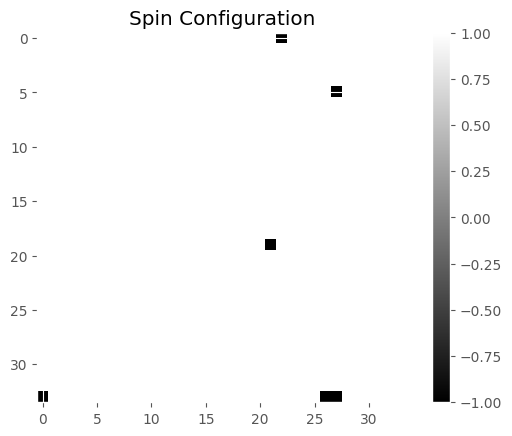

In [6]:
# 格子データのヒートマップを作成
plt.imshow(simulation.lattice, cmap='gray', interpolation='nearest')
plt.title('Spin Configuration')
plt.colorbar()

plt.show()

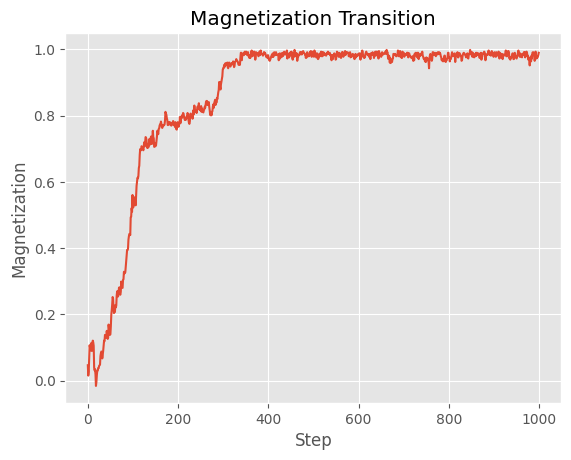

In [7]:
# 磁化率の推移をプロット
plt.plot(magnetization_transition)
plt.xlabel('Step')
plt.ylabel('Magnetization')
plt.title('Magnetization Transition')
plt.show()

# データの生成

In [111]:
# パラメータの設定
J = 1
h = 0.05
beta_values = np.arange(0.05, 1.05, 0.1)
n_steps = 50000
discard_steps = 40000

In [112]:
# データセットの作成
data = {'Beta': [], 'Magnetization': [], 'Lattice': [], 'Label': []}

for beta in beta_values:
    simulation = Squaresimulation(32)  # グリッドのサイズを指定
    magnetization_transition = simulation.compute_magnetization_transition(beta, J, h, n_steps)
    magnetization_transition = magnetization_transition[discard_steps:]
    lattice = simulation.lattice
    label = 1 if beta <= 0.44 else 0
    
    for i in range(0, len(magnetization_transition), 100):
        data['Beta'].append(beta)
        data['Magnetization'].append(magnetization_transition[i])
        data['Lattice'].append(lattice.tolist())
        data['Label'].append(label)

dataset = pd.DataFrame(data)

In [113]:
# 最終的な磁化率の計算
final_magnetizations = dataset.groupby('Beta')['Magnetization'].last().reset_index()

In [252]:
dataset

,Beta,Magnetization,Lattice,Label
0,0.05,-0.021484,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
1,0.05,-0.033203,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
2,0.05,0.000000,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
3,0.05,-0.021484,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
4,0.05,0.041016,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
...,...,...,...,...
995,0.95,0.996094,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
996,0.95,1.000000,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
997,0.95,0.994141,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
998,0.95,0.998047,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0


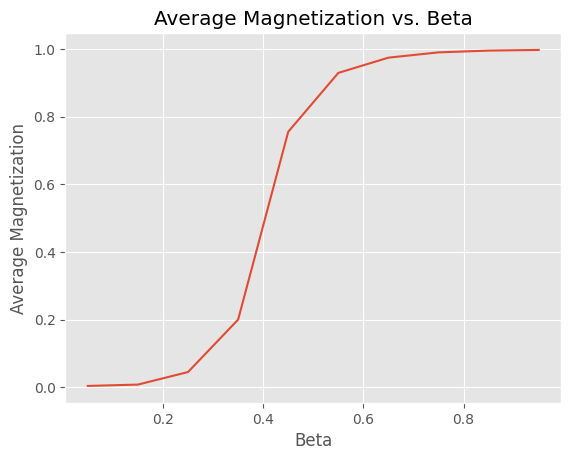

In [253]:
# 各ベータについて平均を計算
average_magnetizations = dataset.groupby('Beta')['Magnetization'].mean().reset_index()

# プロット
plt.plot(average_magnetizations['Beta'], average_magnetizations['Magnetization'])
plt.xlabel('Beta')
plt.ylabel('Average Magnetization')
plt.title('Average Magnetization vs. Beta')
plt.grid(True)
plt.show()

In [254]:
# CSVファイルにDataFrameを保存する
dataset.to_csv('ising_square.csv', index=False)

# ニューラルネットワークの実装

In [269]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [270]:
dataset

,Beta,Magnetization,Lattice,Label
0,0.05,-0.021484,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
1,0.05,-0.033203,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
2,0.05,0.000000,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
3,0.05,-0.021484,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
4,0.05,0.041016,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
...,...,...,...,...
995,0.95,0.996094,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
996,0.95,1.000000,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
997,0.95,0.994141,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
998,0.95,0.998047,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0


In [271]:
'''
データセットから訓練データとテストデータを作成
テストデータは，各betaにつき一つずつ取り出します
'''
columns = ['Beta', 'Magnetization', 'Lattice' , 'Label']
# 新しいDataFrameを作成するための空のリストを用意する
new_data = []

b_len = len(dataset['Beta'])

# 上から100番目ずつの行を抽出してリストに追加する
for i in range(0, b_len, 100):
    new_data.append(dataset.iloc[i])

# リストをDataFrameに変換する
test_dataset = pd.DataFrame(new_data, columns=columns)

In [272]:
test_dataset

,Beta,Magnetization,Lattice,Label
0,0.05,-0.021484,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
100,0.15,-0.058594,"[[1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, ...",1
200,0.25,-0.054688,"[[-1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -...",1
300,0.35,0.193359,"[[1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, ...",1
400,0.45,0.648438,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1...",0
500,0.55,0.900391,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
600,0.65,0.982422,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
700,0.75,0.998047,"[[1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0
800,0.85,0.994141,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
900,0.95,1.000000,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0


In [273]:
train_dataset = dataset.drop(test_dataset.index)

In [274]:
train_dataset

,Beta,Magnetization,Lattice,Label
1,0.05,-0.033203,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
2,0.05,0.000000,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
3,0.05,-0.021484,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
4,0.05,0.041016,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
5,0.05,0.007812,"[[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...",1
...,...,...,...,...
995,0.95,0.996094,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
996,0.95,1.000000,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
997,0.95,0.994141,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0
998,0.95,0.998047,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0


In [275]:
X_train = np.array(train_dataset['Lattice'].tolist())
y_train = np.array(train_dataset['Label'].tolist())
X_test = np.array(test_dataset['Lattice'].tolist())
y_test = np.array(test_dataset['Label'].tolist())

In [276]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (990, 32, 32)
y_train.shape: (990,)
X_test.shape: (10, 32, 32)
y_test.shape: (10,)


In [277]:
# 変形後の配列の形状を定義する
new_shape1 = (X_train.shape[0], X_train.shape[1] * X_train.shape[2])
new_shape2 = (X_test.shape[0], X_train.shape[1] * X_train.shape[2])

# 配列を変形する
new_X_train = X_train.reshape(new_shape1)
new_X_test = X_test.reshape(new_shape2)

print('new_X_train.shape:', new_X_train.shape)
print('new_X_test.shape:', new_X_test.shape)

new_X_train.shape: (990, 1024)
new_X_test.shape: (10, 1024)


In [278]:
# ニューラルネットワークモデルの構築と学習
model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam')
model.fit(new_X_train, y_train)

MLPClassifier()

In [279]:
# テストデータにおける予測値の取得
predictions = model.predict(new_X_test)

In [280]:
predictions

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [281]:
no_predictions = 1 - predictions

In [282]:
beta_values = np.arange(0.05, 1.05, 0.1)

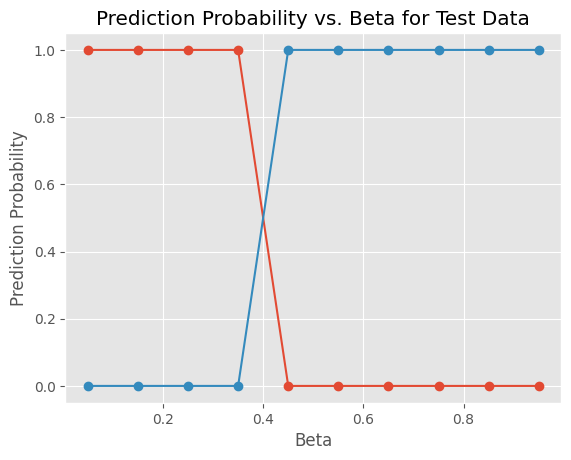

In [283]:
# プロット
plt.plot(beta_values, predictions, 'o-')
plt.plot(beta_values, no_predictions, 'o-')
plt.xlabel('Beta')
plt.ylabel('Prediction Probability')
plt.title('Prediction Probability vs. Beta for Test Data')
plt.grid(True)
plt.show()